In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [33]:
# import 
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
# Load your data into a DataFrame 
train_data = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
train_data['text'] = train_data['text'].replace(np.nan, '', regex=True)
test_data = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test_data['text'] = test_data['text'].replace(np.nan, '', regex=True)

In [35]:
import re

def preprocess(sentence_list):
    stop_words = set(stopwords.words('english'))
    row_sentence_list = []

    for i in sentence_list:
        # Keep only words and digits
        sentence = re.sub(r"\W", " ", i)

        # Remove digits
        sentence = re.sub(r"\d", " ", sentence)

        # Remove extra spaces
        sentence = re.sub(r"\s+[a-z]\s+", " ", sentence, flags=re.I)

        # Remove the space at the beginning of the sentence
        sentence = re.sub(r"^\s", " ", sentence)

        # Remove the space at the ending of the sentence
        sentence = re.sub(r"\s$", " ", sentence)

        # Tokenize and remove stopwords
        words = word_tokenize(sentence)
        sentence = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

        row_sentence_list.append(sentence)

    return row_sentence_list

# Preprocess and save the preprocessed sentences in the DataFrame
train_data['preprocessed_text'] = preprocess(train_data['text'])
test_data['preprocessed_text'] = preprocess(test_data['text'])

# Flatten the list of preprocessed sentences
flat_list = [word for essay in train_data['preprocessed_text'] for word in essay]

word_counts = {}
for word in flat_list:
    word_counts[word] = word_counts.get(word, 0) + 1
    
# Build a vocabulary by keeping words that occur at least min_occurence times
min_occurrence = 40
vocabulary = [word for word, count in word_counts.items() if count >= min_occurrence]

In [36]:
def probability_with_smoothing(vocabulary, essays, alpha=1):
    # Initialize an empty dictionary to store probabilities for each word
    probabilities = {}
    
    essays_count = len(essays)
    vocabulary_size = len(vocabulary)

    # Iterate over each word in the vocabulary 
    for word in vocabulary:
        word_count = 0 # Initialize the count for each word
        for essay in essays: # Iterate over each essay to count the occurrences of the word
            if word in essay: # Check if the word is present in the essay
                word_count += 1

        # Laplace smoothing to calculate the probability of the word
        probability = (word_count + alpha) / (essays_count + alpha * vocabulary_size)
        probabilities[word] = probability

    return probabilities

In [37]:
# Essays written by human (generated == 0)
human_essays = train_data[train_data["generated"]==0]["preprocessed_text"]

# Essays generated by LLM (generated == 1)
llm_essays = train_data[train_data["generated"]==1]["preprocessed_text"]

# Use probability_with_smoothing for human essays, and LLM essays
probabilities_human_essays_smoothed = probability_with_smoothing(vocabulary, human_essays)
probabilities_llm_essays_smoothed = probability_with_smoothing(vocabulary, llm_essays)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data['preprocessed_text'], train_data['generated'], test_size=0.2, random_state=42)

# Classification based on probabilities with smoothing
def classify_essay_with_smoothing(probabilities_human, probabilities_llm, essay):
    score_human = np.prod([probabilities_human[word] for word in essay if word in probabilities_human])
    score_llm = np.prod([probabilities_llm[word] for word in essay if word in probabilities_llm])

    return 0 if score_human > score_llm else 1

# Classify validation essays with smoothing
predicted_labels_val_smoothed = []

for essay in X_val:
    predicted_labels_batch = [classify_essay_with_smoothing(probabilities_human_essays_smoothed, probabilities_llm_essays_smoothed, essay)]
    predicted_labels_val_smoothed.extend(predicted_labels_batch)

# Evaluate accuracy
accuracy_val_smoothed = accuracy_score(y_val, predicted_labels_val_smoothed)

print(f"Accuracy on validation essays with smoothing: {accuracy_val_smoothed}")

Accuracy on validation essays with smoothing: 0.8913043478260869


In [38]:
# Classify test essays with smoothing
predicted_labels_test_smoothed = []
X_test = test_data["preprocessed_text"]

for essay in X_test:
    predicted_labels_test_batch = [classify_essay_with_smoothing(probabilities_human_essays_smoothed, probabilities_llm_essays_smoothed, essay)]
    predicted_labels_test_smoothed.extend(predicted_labels_test_batch)
    
# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'id': test_data['id'],  # Assuming the test data has an 'id' column
    'generated': predicted_labels_test_smoothed
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv("submission.csv", index=False)

In [39]:
# Flatten the list of preprocessed sentences
flat_list = [word for essay in train_data['preprocessed_text'] for word in essay]

word_counts = {}
for word in flat_list:
    word_counts[word] = word_counts.get(word, 0) + 1

# Function to get top N words predicting a class
def top_n_predictive_words(probabilities, class_label, n=10):
    sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
    top_n_words = [word for word, prob in sorted_probabilities[:n]]
    print(f"Top {n} words predicting class {class_label}: {top_n_words}")
    return top_n_words

# Get top 10 words predicting each class
top_human_words = top_n_predictive_words(probabilities_human_essays_smoothed, class_label=0, n=10)
top_llm_words = top_n_predictive_words(probabilities_llm_essays_smoothed, class_label=1, n=10)

# Identify the word that most likely predicts human essays
most_likely_human_word = max(probabilities_human_essays_smoothed, key=probabilities_human_essays_smoothed.get)
print(f"The word most likely predicting human essays: {most_likely_human_word}")


Top 10 words predicting class 0: ['people', 'would', 'states', 'one', 'also', 'many', 'even', 'get', 'way', 'much']
Top 10 words predicting class 1: ['better', 'citizens', 'people', 'goes', 'states', 'tend', 'areas', 'however', 'two', 'college']
The word most likely predicting human essays: people


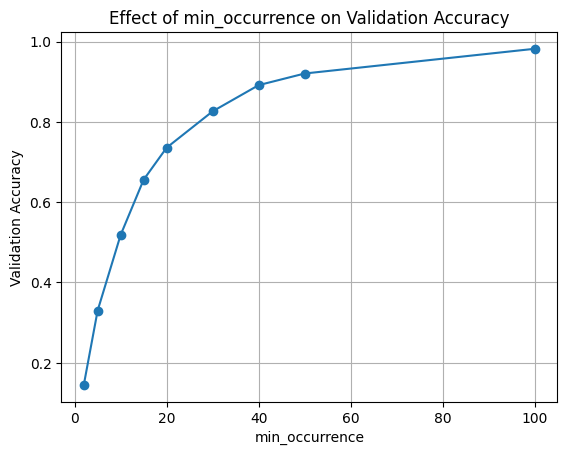

In [40]:
import matplotlib.pyplot as plt

# List to store results
min_occurrence_values = []
accuracy_values = []
specific_min_occurrence_values = [2, 5, 10, 15, 20, 30, 40, 50, 100]

for min_occurrence in specific_min_occurrence_values:
    vocabulary = [word for word, count in word_counts.items() if count >= min_occurrence]

    # Calculate probabilities and classify essays
    probabilities_human_essays_smoothed = probability_with_smoothing(vocabulary, human_essays)
    probabilities_llm_essays_smoothed = probability_with_smoothing(vocabulary, llm_essays)

    predicted_labels_val_smoothed = []
    for essay in X_val:
        predicted_labels_batch = [classify_essay_with_smoothing(probabilities_human_essays_smoothed, probabilities_llm_essays_smoothed, essay)]
        predicted_labels_val_smoothed.extend(predicted_labels_batch)
        
    accuracy_val_smoothed = accuracy_score(y_val, predicted_labels_val_smoothed)

    min_occurrence_values.append(min_occurrence)
    accuracy_values.append(accuracy_val_smoothed)

# Plot the results
plt.plot(min_occurrence_values, accuracy_values, marker='o')
plt.xlabel('min_occurrence')
plt.ylabel('Validation Accuracy')
plt.title('Effect of min_occurrence on Validation Accuracy')
plt.grid(True)
plt.show()
